<a href="https://colab.research.google.com/github/dipanshuverma98/Sarcasm_Model/blob/main/SarcasmDetectionModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Sarcasm
import json
import pandas as pd
import re
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense
from tensorflow.keras.callbacks import ModelCheckpoint

data = []
with open("Sarcasm_Headlines_Dataset.json", "r") as file:
    for line in file:
        try:
            data.append(json.loads(line))
        except json.JSONDecodeError as e:
            print(f"Skipping invalid line: {line.strip()} due to error: {e}")

df = pd.DataFrame(data)

print(df.head())

                                        article_link  \
0  https://www.huffingtonpost.com/entry/versace-b...   
1  https://www.huffingtonpost.com/entry/roseanne-...   
2  https://local.theonion.com/mom-starting-to-fea...   
3  https://politics.theonion.com/boehner-just-wan...   
4  https://www.huffingtonpost.com/entry/jk-rowlin...   

                                            headline  is_sarcastic  
0  former versace store clerk sues over secret 'b...             0  
1  the 'roseanne' revival catches up to our thorn...             0  
2  mom starting to fear son's web series closest ...             1  
3  boehner just wants wife to listen, not come up...             1  
4  j.k. rowling wishes snape happy birthday in th...             0  


In [ ]:
!pip install emoji

In [ ]:
import re
import emoji

def preprocess_text(text):
    text = text.lower()

    text = re.sub(r"http\S+|www\S+|https\S+", "", text)
    text = emoji.demojize(text, delimiters=(" ", " "))
    text = re.sub(r"[^a-zA-Z0-9#@' ]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()

    return text


In [ ]:
df["text"] = df["headline"].apply(preprocess_text)

texts = df["text"].values
labels = df["is_sarcastic"].values


In [ ]:
MAX_VOCAB_SIZE = 10000
MAX_SEQUENCE_LENGTH = 50
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, oov_token="<OOV>")
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
padded_sequences = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, padding="post", truncating="post")

X_train, X_test, y_train, y_test = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)


In [52]:
# BiLSTM
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout
model = Sequential([
    Embedding(input_dim=MAX_VOCAB_SIZE, output_dim=128, input_length=MAX_SEQUENCE_LENGTH),

    Bidirectional(LSTM(32, return_sequences=True, dropout=0.5, recurrent_dropout=0.5)),
    Bidirectional(LSTM(16, dropout=0.5, recurrent_dropout=0.5)),

    Dense(32, activation="relu"),
    Dropout(0.5),
    Dense(1, activation="sigmoid")
])
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

checkpoint = ModelCheckpoint("best_bilstm_model.h5", save_best_only=True, monitor="val_accuracy", mode="max")


history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=5, batch_size=32,
    callbacks=[checkpoint]
)

Epoch 1/5
668/668 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - accuracy: 0.6620 - loss: 0.5721

668/668 ━━━━━━━━━━━━━━━━━━━━ 153s 204ms/step - accuracy: 0.6622 - loss: 0.5720 - val_accuracy: 0.8459 - val_loss: 0.3436
Epoch 2/5
668/668 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - accuracy: 0.9021 - loss: 0.2644

668/668 ━━━━━━━━━━━━━━━━━━━━ 141s 210ms/step - accuracy: 0.9021 - loss: 0.2644 - val_accuracy: 0.8639 - val_loss: 0.3317
Epoch 3/5
668/668 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - accuracy: 0.9376 - loss: 0.1795

668/668 ━━━━━━━━━━━━━━━━━━━━ 169s 253ms/step - accuracy: 0.9376 - loss: 0.1795 - val_accuracy: 0.8647 - val_loss: 0.3637
Epoch 4/5
668/668 ━━━━━━━━━━━━━━━━━━━━ 166s 199ms/step - accuracy: 0.9558 - loss: 0.1302 - val_accuracy: 0.8581 - val_loss: 0.4560
Epoch 5/5
668/668 ━━━━━━━━━━━━━━━━━━━━ 142s 198ms/step - accuracy: 0.9639 - loss: 0.1023 - val_accuracy: 0.8502 - val_loss: 0.4821


In [53]:

best_model = load_model("best_bilstm_model.h5")

loss, accuracy = best_model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

def predict_sarcasm(text):
    seq = tokenizer.texts_to_sequences([preprocess_text(text)])
    padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH, padding="post", truncating="post")
    pred = best_model.predict(padded)[0][0]
    return "Sarcasm" if pred > 0.5 else "Not Sarcasm"

print(predict_sarcasm("Oh wow, that’s EXACTLY what I wanted!"))


167/167 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - accuracy: 0.8666 - loss: 0.3584
Test Accuracy: 0.8647
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Not Sarcasm


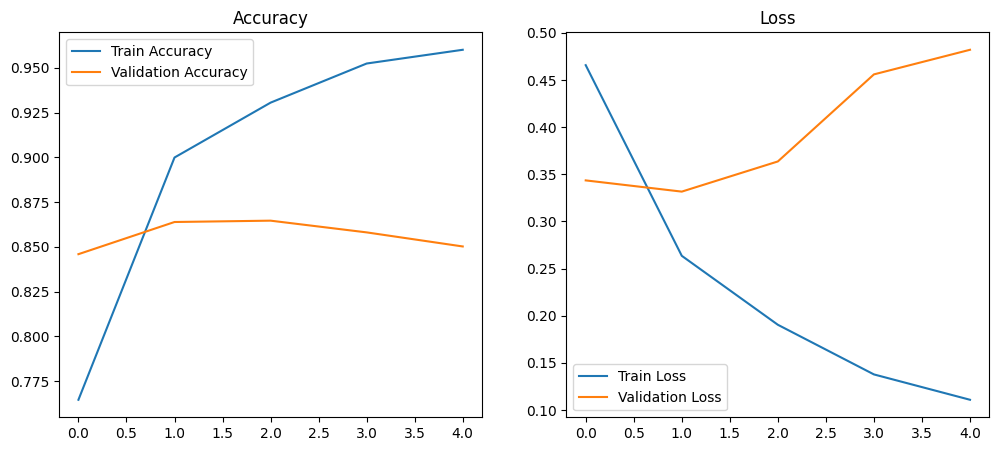

In [54]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.legend()
plt.title("Accuracy")

plt.subplot(1,2,2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.title("Loss")

plt.show()